In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from tensorflow.keras import layers, Model, optimizers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, Input, Conv3D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import os
from keras.regularizers import l2
from keras.constraints import MinMaxNorm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import backend as K
# Set default floating-point type to float64
tf.keras.backend.set_floatx('float64')

In [3]:
sorted_concatenated_csv = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/1st run concat.csv"
data = pd.read_csv(sorted_concatenated_csv)
data.drop(columns=['zCOM'], inplace=True)
print(data.head())
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)
def replace_negative_with_zero(data):
    num_negative_values = (data < 0).sum().sum()
    data[data < 0] = 0

    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(data[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

   mcsteps  xCOM  yCOM           il8  il1  il6  il10  tnf  tgf
0        0    33    22  3.750408e-07  0.0  0.0   0.0  0.0  0.0
1        0    11    32  4.793328e-09  0.0  0.0   0.0  0.0  0.0
2        0    30    35  8.997935e-09  0.0  0.0   0.0  0.0  0.0
3        0    17    40  1.781103e-08  0.0  0.0   0.0  0.0  0.0
4        0    21    23  4.789621e-09  0.0  0.0   0.0  0.0  0.0
       time  xCOM  yCOM           il8           il1           il6  \
0         0    33    22  3.750408e-07  0.000000e+00  0.000000e+00   
1         0    11    32  4.793328e-09  0.000000e+00  0.000000e+00   
2         0    30    35  8.997935e-09  0.000000e+00  0.000000e+00   
3         0    17    40  1.781103e-08  0.000000e+00  0.000000e+00   
4         0    21    23  4.789621e-09  0.000000e+00  0.000000e+00   
...     ...   ...   ...           ...           ...           ...   
86155   100    49    35 -8.886183e-11  6.343394e-10  1.206925e-08   
86156   100    36     4  1.334245e-07  1.665160e-07  1.305691e-08   
8

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_7584\1681361132.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_7584\1681361132.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_7584\1681361132.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\i

In [4]:
print("Number of arrays:", len(arrays))
array = arrays[1]
print("Shape of the array:", array.shape)
print("Value at position (0,45):", array[0,45])

Number of arrays: 101
Shape of the array: (50, 50, 6)
Value at position (0,45): [0.00000e+00 6.79662e-23 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]


In [5]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

print(input_sequences.shape)
print(output_values.shape)

(91, 10, 50, 50, 6)
(91, 50, 50, 6)


In [6]:
# Metrics and lr schedule callback
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 400:
        return 1e-5
    else:
        return 1e-6

def r_squared(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def average_relative_rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square((y_pred - y_true) / tf.keras.backend.clip(tf.keras.backend.abs(y_true), tf.keras.backend.epsilon(), None))))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.3 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

In [23]:
input_shape = (10, 50, 50, 6)
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
   
    x= layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x= Reshape((sequence_length, -1))(x)
    x= layers.LSTM(units=64, return_sequences=True)(x)
    x= layers.LSTM(units=64)(x)
    x= layers.Dense(units=50*50*6, activation='relu')(x)
    output_layer = layers.Reshape((50, 50, 6))(x)

    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

In [7]:
input_shape = (10, 50, 50, 6)
# model architecture
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 6, activation='relu')(x) 
    output_layer = layers.Reshape((50, 50, 6))(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

In [16]:
# Initialize the parameters
nx = 50
ny = nx
dx = 1.
total_cytokines = 6
total_celltypes = 10
boundaryat = 50
relaxationmcs = 10000
true_size = 5  # in cm
fipy_duration = int(1)  # in hours
s_mcs = 60.
h_mcs = 1 / 60.
true_mass = 1  # in picograms
lineconv = true_size / nx  # cm per grid
areaconv = true_size ** 2 / nx ** 2
volumeconv = (true_size ** 2 * 1) / (nx ** 2 * 1)  # unit length along z (2D assumption) ml or cm3 as base
massconv = true_mass

# Parameters for IL-8
Dil8 = 2.09 * 10 ** -6 * s_mcs / areaconv
muil8 = 0.2 * h_mcs
keil8 = 234 * 10 ** -5 * volumeconv * h_mcs
kndnil8 = 1.46 * 10 ** -5 * volumeconv * h_mcs
thetanail8 = 3.024 * 10 ** -5 * volumeconv * h_mcs

# Parameters for IL-1β
Dil1 = 3 * 10 ** -7 * s_mcs / areaconv
muil1 = 0.6 * h_mcs
knail1 = 225 * 10 ** -5 * volumeconv * h_mcs

# Parameters for IL-6
Dil6 = 8.49 * 10 ** -8 * s_mcs / areaconv
muil6 = 0.5 * h_mcs
km1il6 = 250 * 10 ** -5 * volumeconv * h_mcs

# Parameters for IL-10
Dil10 = 1.45 * 10 ** -8 * s_mcs / areaconv
muil10 = 0.5 * h_mcs
km2il10 = 45 * 10 ** -5 * volumeconv * h_mcs

# Parameters for TNFα
Dtnf = 4.07 * 10 ** -9 * s_mcs / areaconv
mutnf = 0.5 * 0.225 * h_mcs
knatnf = 250 * 10 ** -5 * volumeconv * h_mcs
km1tnf = 70 * 10 ** -5 * volumeconv * h_mcs

# Parameters for TGFβ1
Dtgf = 2.6 * 10 ** -7 * s_mcs / areaconv
mutgf = 0.5 * 1 / 25 * h_mcs
km2tgf = 280 * 10 ** -5 * volumeconv * h_mcs

# Initialize cell presence variables to 1
cellpresente = 1.0
cellpresentndn = 1.0
cellpresentna = 1.0
cellpresentm1 = 1.0
cellpresentm2 = 1.0

# Define the custom loss layer
class CustomLossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        y_pred, y_true, x, y, t = inputs
        
        # Define parameters for IL-8
        params_il8 = {
            'D': Dil8,
            'mu': muil8,
            'source_term': keil8 * cellpresente + kndnil8 * cellpresentndn - thetanail8 * cellpresentna
        }

        # Define parameters for IL-1β
        params_il1 = {
            'D': Dil1,
            'mu': muil1,
            'source_term': knail1 * cellpresentna
        }

        # Define parameters for IL-6
        params_il6 = {
            'D': Dil6,
            'mu': muil6,
            'source_term': km1il6 * cellpresentm1
        }

        # Define parameters for IL-10
        params_il10 = {
            'D': Dil10,
            'mu': muil10,
            'source_term': km2il10 * cellpresentm1
        }

        # Define parameters for TNFα
        params_tnf = {
            'D': Dtnf,
            'mu': mutnf,
            'source_term': knatnf * cellpresentna + km1tnf * cellpresentm1
        }

        # Define parameters for TGFβ1
        params_tgf = {
            'D': Dtgf,
            'mu': mutgf,
            'source_term': km2tgf * cellpresentm2
        }

        # Define the PDE residuals for each cytokine
        def compute_residuals(cytokine_pred, D, mu, source_term):
            with tf.GradientTape(persistent=True) as tape:
                tape.watch([x, y, t])
                phi = cytokine_pred
                phi_t = tape.gradient(phi, t)
                phi_xx = tape.gradient(tape.gradient(phi, x), x)
                phi_yy = tape.gradient(tape.gradient(phi, y), y)
            
            residual = phi_t - D * (phi_xx + phi_yy) + mu * phi - source_term
            return residual
        
        # Split y_pred and y_true into individual cytokines
        il8_pred, il1_pred, il6_pred, il10_pred, tnf_pred, tgf_pred = tf.split(y_pred, 6, axis=-1)
        il8_true, il1_true, il6_true, il10_true, tnf_true, tgf_true = tf.split(y_true, 6, axis=-1)

        # Compute physics loss for all cytokines
        physics_loss = 0
        for cytokine_pred, params in zip(
            [il8_pred, il1_pred, il6_pred, il10_pred, tnf_pred, tgf_pred], 
            [params_il8, params_il1, params_il6, params_il10, params_tnf, params_tgf]
        ):
            residuals = compute_residuals(cytokine_pred, params['D'], params['mu'], params['source_term'])
            physics_loss += tf.reduce_mean(tf.square(residuals))
        
        # Compute total loss
        data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        total_loss = data_loss + physics_loss
        return total_loss
x = tf.constant([0.0], dtype=tf.float32)
y = tf.constant([0.0], dtype=tf.float32)
t = tf.constant([0.0], dtype=tf.float32)

In [63]:
import tensorflow as tf

# Define the parameters for the PDE solver
Dil8 = 2.09e-6  # Diffusion coefficient for IL-8
Dil1 = 3e-7     # Diffusion coefficient for IL-1
Dil6 = 8.49e-8  # Diffusion coefficient for IL-6
Dil10 = 1.45e-8  # Diffusion coefficient for IL-10
Dtnf = 4.07e-9  # Diffusion coefficient for TNF
Dtgf = 2.6e-7   # Diffusion coefficient for TGF

muil8 = 0.2     # Degradation rate for IL-8
muil1 = 0.6     # Degradation rate for IL-1
muil6 = 0.5     # Degradation rate for IL-6
muil10 = 0.5    # Degradation rate for IL-10
mutnf = 0.1125  # Degradation rate for TNF
mutgf = 0.02    # Degradation rate for TGF

keil8 = 234e-5       # Production rate for IL-8
kndnil8 = 1.46e-5    # Additional source term for IL-8
thetanail8 = 3.024e-5  # Negative feedback/inhibition term for IL-8
knail1 = 225e-5      # Production rate for IL-1
km1il6 = 250e-5      # Production rate for IL-6
km2il10 = 45e-5      # Production rate for IL-10
knatnf = 250e-5      # Production rate for TNF
km1tnf = 70e-5       # Additional source term for TNF
km2tgf = 280e-5      # Production rate for TGF

# Define the custom loss layer
class CustomLossLayer(tf.keras.layers.Layer):
        
    def call(self, inputs):
        y_pred, y_true = inputs
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Compute the physical constraints
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(y_pred)
            il8, il1, il6, il10, tnf, tgf = tf.split(y_pred, num_or_size_splits=6, axis=-1)
            
 
               
            # Compute spatial gradients for each cytokine
            grad_il8 = tape.gradient(il8, y_pred)
            grad_il1 = tape.gradient(il1, y_pred)
            grad_il6 = tape.gradient(il6, y_pred)
            grad_il10 = tape.gradient(il10, y_pred)
            grad_tnf = tape.gradient(tnf, y_pred)
            grad_tgf = tape.gradient(tgf, y_pred)
            
            # Compute the Laplacian (second spatial derivatives) for each cytokine
            # Compute the Laplacian (second spatial derivatives) for each cytokine
            laplacian_il8_x = tape.gradient(grad_il8, y_pred)
            laplacian_il1_x = tape.gradient(grad_il1, y_pred)
            laplacian_il6_x = tape.gradient(grad_il6, y_pred)
            laplacian_il10_x = tape.gradient(grad_il10, y_pred)
            laplacian_tnf_x = tape.gradient(grad_tnf, y_pred)
            laplacian_tgf_x = tape.gradient(grad_tgf, y_pred)
            
            laplacian_il8_y = tape.gradient(grad_il8, y_pred)
            laplacian_il1_y = tape.gradient(grad_il1, y_pred)
            laplacian_il6_y = tape.gradient(grad_il6, y_pred)
            laplacian_il10_y = tape.gradient(grad_il10, y_pred)
            laplacian_tnf_y = tape.gradient(grad_tnf, y_pred)
            laplacian_tgf_y = tape.gradient(grad_tgf, y_pred)
            
            laplacian_il8 = laplacian_il8_x + laplacian_il8_y
            laplacian_il1 = laplacian_il1_x + laplacian_il1_y
            laplacian_il6 = laplacian_il6_x + laplacian_il6_y
            laplacian_il10 = laplacian_il10_x + laplacian_il10_y
            laplacian_tnf = laplacian_tnf_x + laplacian_tnf_y
            laplacian_tgf = laplacian_tgf_x + laplacian_tgf_y

            
            print("laplacian_il8:", laplacian_il8)
            print("laplacian_il1:", laplacian_il1)
            print("laplacian_il6:", laplacian_il6)
            print("laplacian_il10:", laplacian_il10)
            print("laplacian_tnf:", laplacian_tnf)
            print("laplacian_tgf:", laplacian_tgf)

            # Compute the reaction-diffusion equations for each cytokine
            rd_il8 = Dil8 * laplacian_il8 - muil8 * il8 + keil8 * il8 + kndnil8 * il8 - thetanail8 * il8
            rd_il1 = Dil1 * laplacian_il1 - muil1 * il1 + knail1 * il1
            rd_il6 = Dil6 * laplacian_il6 - muil6 * il6 + km1il6 * il6
            rd_il10 = Dil10 * laplacian_il10 - muil10 * il10 + km2il10 * il10
            rd_tnf = Dtnf * laplacian_tnf - mutnf * tnf + knatnf * tnf + km1tnf * tnf
            rd_tgf = Dtgf * laplacian_tgf - mutgf * tgf + km2tgf * tgf

        # Neumann boundary condition (zero-flux for simplicity)
        # Assuming y_pred has shape (batch_size, num_points, 6) and the boundaries are the first and last points
        boundary_il8_x = grad_il8[:, [0, -1], :, :]
        boundary_il8_y = grad_il8[:, :, [0, -1], :]
        boundary_il1_x = grad_il1[:, [0, -1], :, :]
        boundary_il1_y = grad_il1[:, :, [0, -1], :]
        boundary_il6_x = grad_il6[:, [0, -1], :, :]
        boundary_il6_y = grad_il6[:, :, [0, -1], :]
        boundary_il10_x = grad_il10[:, [0, -1], :, :]
        boundary_il10_y = grad_il10[:, :, [0, -1], :]
        boundary_tnf_x = grad_tnf[:, [0, -1], :, :]
        boundary_tnf_y = grad_tnf[:, :, [0, -1], :]
        boundary_tgf_x = grad_tgf[:, [0, -1], :, :]
        boundary_tgf_y = grad_tgf[:, :, [0, -1], :]

        boundary_loss_il8 = tf.reduce_mean(tf.square(boundary_il8_x)) + tf.reduce_mean(tf.square(boundary_il8_y))
        boundary_loss_il1 = tf.reduce_mean(tf.square(boundary_il1_x)) + tf.reduce_mean(tf.square(boundary_il1_y))
        boundary_loss_il6 = tf.reduce_mean(tf.square(boundary_il6_x)) + tf.reduce_mean(tf.square(boundary_il6_y))
        boundary_loss_il10 = tf.reduce_mean(tf.square(boundary_il10_x)) + tf.reduce_mean(tf.square(boundary_il10_y))
        boundary_loss_tnf = tf.reduce_mean(tf.square(boundary_tnf_x)) + tf.reduce_mean(tf.square(boundary_tnf_y))
        boundary_loss_tgf = tf.reduce_mean(tf.square(boundary_tgf_x)) + tf.reduce_mean(tf.square(boundary_tgf_y))

        total_boundary_loss = (boundary_loss_il8 +
                               boundary_loss_il1 +
                               boundary_loss_il6 +
                               boundary_loss_il10 +
                               boundary_loss_tnf +
                               boundary_loss_tgf)
        
        # Compute the physics loss for each cytokine
        physics_loss_il8 = tf.reduce_mean(tf.square(rd_il8))
        physics_loss_il1 = tf.reduce_mean(tf.square(rd_il1))
        physics_loss_il6 = tf.reduce_mean(tf.square(rd_il6))
        physics_loss_il10 = tf.reduce_mean(tf.square(rd_il10))
        physics_loss_tnf = tf.reduce_mean(tf.square(rd_tnf))
        physics_loss_tgf = tf.reduce_mean(tf.square(rd_tgf))
        
        # Aggregate the physics losses
        total_physics_loss = (physics_loss_il8 + 
                              physics_loss_il1 + 
                              physics_loss_il6 + 
                              physics_loss_il10 + 
                              physics_loss_tnf + 
                              physics_loss_tgf)
        
        total_loss = mse_loss + total_physics_loss + total_boundary_loss
        self.add_loss(total_loss)
        return y_pred
# Create input placeholders for x, y, t

In [69]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the parameters for the PDE solver
Dil8 = 2.09e-6  # Diffusion coefficient for IL-8
Dil1 = 3e-7     # Diffusion coefficient for IL-1
Dil6 = 8.49e-8  # Diffusion coefficient for IL-6
Dil10 = 1.45e-8  # Diffusion coefficient for IL-10
Dtnf = 4.07e-9  # Diffusion coefficient for TNF
Dtgf = 2.6e-7   # Diffusion coefficient for TGF

# Define the diffusion coefficients for each cytokine
diffusion_coefficients = tf.constant([Dil8, Dil1, Dil6, Dil10, Dtnf, Dtgf], dtype=tf.float64)

# Define the reaction term (example: simple linear degradation)
def reaction_term(C, k=0.1):
    return -k * C

# Calculate the Laplacian using finite difference
def laplacian(C, dx):
    C_xx = (C[:, 2:, 1:-1, :] - 2 * C[:, 1:-1, 1:-1, :] + C[:, :-2, 1:-1, :]) / dx**2
    C_yy = (C[:, 1:-1, 2:, :] - 2 * C[:, 1:-1, 1:-1, :] + C[:, 1:-1, :-2, :]) / dx**2
    return C_xx + C_yy

# Function to calculate the PDE residuals
def pde_residuals(C, dx, dt):
    C_t = (C[1:, 1:-1, 1:-1, :] - C[:-1, 1:-1, 1:-1, :]) / dt
    laplacian_C = laplacian(C, dx)
    
    residuals = []
    for i in range(6):
        diffusion_term = diffusion_coefficients[i] * laplacian_C[:, :, :, i]
        reaction_term_C = reaction_term(C[:, 1:-1, 1:-1, i])
        residual = C_t[:, :, :, i] - (diffusion_term + reaction_term_C)
        residuals.append(tf.expand_dims(residual, axis=-1))
    
    return tf.concat(residuals, axis=-1)

# Neumann boundary condition
def neumann_boundary_loss(C):
    boundary_loss = 0
    for i in range(6):
        C_i = C[:, :, :, i]
        # Neumann BC: gradient at the boundary should be zero
        grad_left = C_i[:, :, 1] - C_i[:, :, 0]
        grad_right = C_i[:, :, -1] - C_i[:, :, -2]
        grad_top = C_i[:, 1, :] - C_i[:, 0, :]
        grad_bottom = C_i[:, -1, :] - C_i[:, -2, :]
        
        boundary_loss += tf.reduce_mean(tf.square(grad_left))
        boundary_loss += tf.reduce_mean(tf.square(grad_right))
        boundary_loss += tf.reduce_mean(tf.square(grad_top))
        boundary_loss += tf.reduce_mean(tf.square(grad_bottom))
    
    return boundary_loss

# Custom loss layer
class CustomLossLayer(layers.Layer):
    def __init__(self, dx=0.1, dt=0.01, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.dx = dx
        self.dt = dt

    def call(self, inputs):
        y_pred, y_true = inputs
        # Compute the PDE residuals
        residuals = pde_residuals(y_pred, self.dx, self.dt)
        pde_loss = tf.reduce_mean(tf.square(residuals))
        
        # Compute the boundary loss
        boundary_loss = neumann_boundary_loss(y_pred)
        
        total_loss = pde_loss + boundary_loss
        self.add_loss(total_loss)
        
        return y_pred

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2

# Define the parameters for the PDE solver
Dil8 = 2.09e-6  # Diffusion coefficient for IL-8
Dil1 = 3e-7     # Diffusion coefficient for IL-1
Dil6 = 8.49e-8  # Diffusion coefficient for IL-6
Dil10 = 1.45e-8  # Diffusion coefficient for IL-10
Dtnf = 4.07e-9  # Diffusion coefficient for TNF
Dtgf = 2.6e-7   # Diffusion coefficient for TGF

# Define the diffusion coefficients for each cytokine
diffusion_coefficients = tf.constant([Dil8, Dil1, Dil6, Dil10, Dtnf, Dtgf], dtype=tf.float64)

# Define the reaction term (example: simple linear degradation)
def reaction_term(C, k=0.1):
    return -k * C

# Calculate the Laplacian using finite difference
def laplacian(C, dx):
    C_xx = (C[:, 2:, 1:-1, 1:-1, :] - 2 * C[:, 1:-1, 1:-1, 1:-1, :] + C[:, :-2, 1:-1, 1:-1, :]) / dx**2
    C_yy = (C[:, 1:-1, 2:, 1:-1, :] - 2 * C[:, 1:-1, 1:-1, 1:-1, :] + C[:, 1:-1, :-2, 1:-1, :]) / dx**2
    return C_xx + C_yy

# Function to calculate the PDE residuals
def pde_residuals(C, dx, dt):
    C_t = (C[1:, 1:-1, 1:-1, 1:-1, :] - C[:-1, 1:-1, 1:-1, 1:-1, :]) / dt
    laplacian_C = laplacian(C, dx)
    
    residuals = []
    for i in range(6):
        diffusion_term = diffusion_coefficients[i] * laplacian_C[..., i]
        reaction_term_C = reaction_term(C[:, 1:-1, 1:-1, 1:-1, i])
        # Ensuring shapes are compatible for addition and subtraction
        diffusion_term = tf.expand_dims(diffusion_term, axis=-1)
        reaction_term_C = tf.expand_dims(reaction_term_C, axis=-1)
        C_t_i = tf.expand_dims(C_t[..., i], axis=-1)
        residual = C_t_i - (diffusion_term + reaction_term_C)
        residuals.append(residual)
    
    return tf.concat(residuals, axis=-1)

# Neumann boundary condition
def neumann_boundary_loss(C):
    boundary_loss = 0
    for i in range(6):
        C_i = C[:, :, :, :, i]
        # Neumann BC: gradient at the boundary should be zero
        grad_left = C_i[:, :, :, 1] - C_i[:, :, :, 0]
        grad_right = C_i[:, :, :, -1] - C_i[:, :, :, -2]
        grad_top = C_i[:, :, 1, :] - C_i[:, :, 0, :]
        grad_bottom = C_i[:, :, -1, :] - C_i[:, :, -2, :]
        
        boundary_loss += tf.reduce_mean(tf.square(grad_left))
        boundary_loss += tf.reduce_mean(tf.square(grad_right))
        boundary_loss += tf.reduce_mean(tf.square(grad_top))
        boundary_loss += tf.reduce_mean(tf.square(grad_bottom))
    
    return boundary_loss

# Custom loss layer
class CustomLossLayer(layers.Layer):
    def __init__(self, dx=0.1, dt=0.01, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.dx = dx
        self.dt = dt

    def call(self, inputs):
        y_pred, y_true = inputs
        # Compute the PDE residuals
        residuals = pde_residuals(y_pred, self.dx, self.dt)
        pde_loss = tf.reduce_mean(tf.square(residuals))
        
        # Compute the boundary loss
        boundary_loss = neumann_boundary_loss(y_pred)
        
        total_loss = pde_loss + boundary_loss
        self.add_loss(total_loss)
        
        return y_pred

# Model architecture
def create_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 6, activation='relu')(x) 
    output_layer = layers.Reshape((50, 50, 6))(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

input_shape = (10, 50, 50, 6)
model = create_model(input_shape)

# Apply the custom loss layer
y_true = layers.Input(shape=(50, 50, 6))
custom_loss_layer = CustomLossLayer()([model.output, y_true])
final_model = Model(inputs=[model.input, y_true], outputs=custom_loss_layer)


# Example custom metric (Placeholder)
def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

def lr_schedule(epoch, lr):
    if epoch > 10:
        lr = lr * 0.1
    return lr

# Data split
train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

# Callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
initial_lr = 1e-4

# Compile and fit the model
final_model.compile(optimizer=Adam(learning_rate=initial_lr), metrics=[r_squared, 'mape', 'msle', 'mae'])

history = final_model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=100, batch_size=40, callbacks=[lr_scheduler, early_stopping])


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

class CustomLossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.mse = MeanSquaredError()

    def build(self, input_shape):
        super(CustomLossLayer, self).build(input_shape)

    def call(self, inputs):
        y_pred, y_true = inputs

        # Data loss (MSE)
        data_loss = self.mse(y_true, y_pred)

        # PDE residuals (Simple Diffusion Equation)
        # Assuming y_pred shape: (batch_size, 50, 50, 6)
        y_pred_pad = tf.pad(y_pred, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='SYMMETRIC')
        
        # Compute second-order derivatives using central finite differences
        d2y_dx2 = (y_pred_pad[:, 2:, 1:-1, :] - 2 * y_pred_pad[:, 1:-1, 1:-1, :] + y_pred_pad[:, :-2, 1:-1, :])
        d2y_dy2 = (y_pred_pad[:, 1:-1, 2:, :] - 2 * y_pred_pad[:, 1:-1, 1:-1, :] + y_pred_pad[:, 1:-1, :-2, :])

        diffusion_residual = d2y_dx2 + d2y_dy2
        pde_loss = tf.reduce_mean(tf.square(diffusion_residual))

        # Boundary loss (Neumann boundary condition)
        # Here we assume zero Neumann boundary condition for simplicity
        boundary_loss = tf.reduce_mean(tf.square(y_pred[:, 0, :, :] - y_pred[:, 1, :, :]))
        boundary_loss += tf.reduce_mean(tf.square(y_pred[:, -1, :, :] - y_pred[:, -2, :, :]))
        boundary_loss += tf.reduce_mean(tf.square(y_pred[:, :, 0, :] - y_pred[:, :, 1, :]))
        boundary_loss += tf.reduce_mean(tf.square(y_pred[:, :, -1, :] - y_pred[:, :, -2, :]))

        # Combined loss
        total_loss = data_loss + pde_loss + boundary_loss
        return total_loss

# Instantiate the custom loss layer
custom_loss_layer = CustomLossLayer()

In [34]:
# Apply the custom loss layer
y_true = layers.Input(shape=(50, 50, 6))
loss = custom_loss_layer([model.output, y_true])
final_model = Model(inputs=[model.input, y_true], outputs=loss)

# data split
train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
initial_lr = 1e-4

# compile, fit
final_model.compile(optimizer=Adam(learning_rate=initial_lr),  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = final_model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=100, batch_size=40, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
2/2 [==============================] - 2s 900ms/step - loss: 4.1757e-11 - r_squared: 0.0102 - mape: 7.5199 - accuracy: 0.0035 - average_relative_rmse: 0.2678 - msle: 4.2135e-12 - mae: 4.1402e-07 - val_loss: 3.8414e-12 - val_r_squared: 0.0311 - val_mape: 9.4702 - val_accuracy: 0.0044 - val_average_relative_rmse: 0.2968 - val_msle: 9.3499e-12 - val_mae: 6.6077e-07 - lr: 1.0000e-04
Epoch 2/100
2/2 [==============================] - 1s 315ms/step - loss: 1.5030e-11 - r_squared: 0.0151 - mape: 7.5199 - accuracy: 0.0035 - average_relative_rmse: 0.2667 - msle: 4.2135e-12 - mae: 4.1402e-07 - val_loss: 3.3954e-11 - val_r_squared: 0.0311 - val_mape: 9.4702 - val_accuracy: 0.0044 - val_average_relative_rmse: 0.2968 - val_msle: 9.3499e-12 - val_mae: 6.6077e-07 - lr: 1.0000e-04
Epoch 3/100
2/2 [==============================] - 1s 348ms/step - loss: 2.6723e-11 - r_squared: 0.0103 - mape: 7.5199 - accuracy: 0.0035 - average_relative_rmse: 0.2680 - msle: 4.2135e-12 - mae: 4.1402e-07 - val

In [35]:
y_pred = model.predict(X_test)

loss = final_model.evaluate([X_test, y_test], y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 0s 174ms/step - loss: 1.4312e-21 - r_squared: -0.0188 - mape: 10.8785 - accuracy: 0.0044 - average_relative_rmse: 0.3174 - msle: 1.1462e-11 - mae: 7.5142e-07
Test Loss: [1.4312044562423532e-21, -0.018752332141696026, 10.878455843665142, 0.004375438596491228, 0.31743616922376405, 1.1462144987755703e-11, 7.514240587690857e-07]


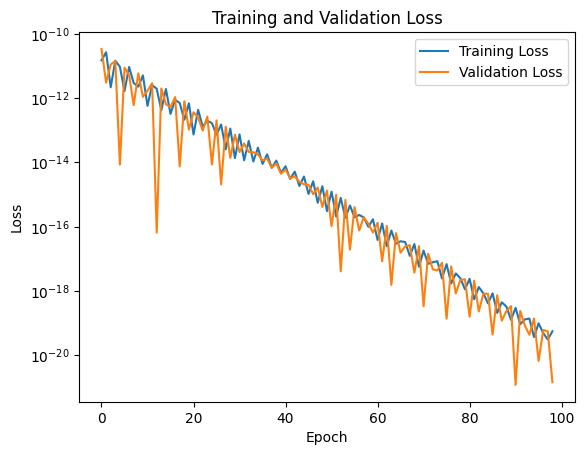

In [36]:
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# save the plot to the specified folder
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

1/1 [==============================] - 0s 21ms/step
(2500, 6)
(2500, 6)


C:\Users\Ioannis\AppData\Local\Temp\ipykernel_7584\2080952785.py:51: RuntimeWarning: divide by zero encountered in log
  log_y_test_grid = np.log(y_test_grid)
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_7584\2080952785.py:52: RuntimeWarning: divide by zero encountered in log
  log_y_pred_grid = np.log(y_pred_grid)


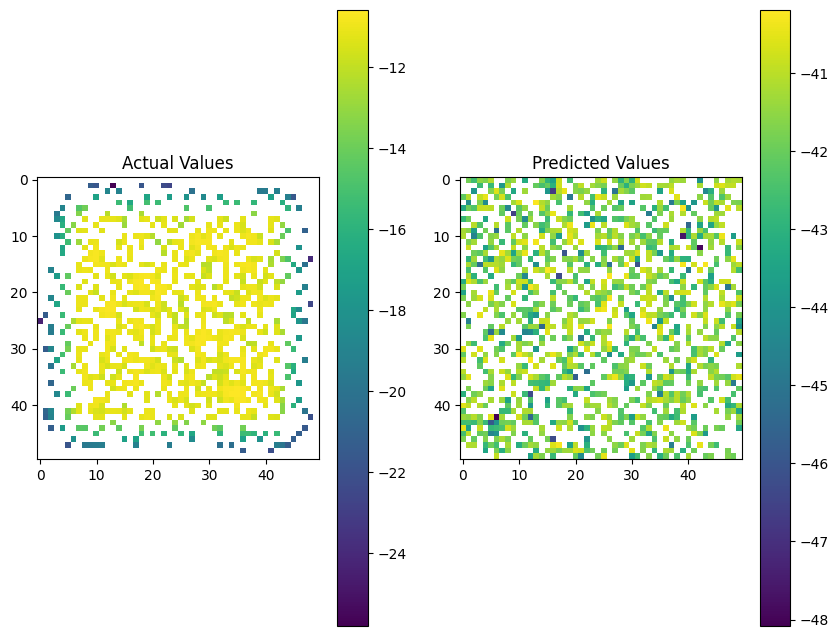

In [37]:
y_pred = model.predict(X_test)

y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Create arrays for x and y coordinates for the best timestep
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Create the DataFrame for the best timestep
df_best_timestep = pd.DataFrame({
    'X': X,
    'Y': Y,
    **{f'feature_{i+1}': best_y_pred_flattened[:, i] for i in range(y_pred_shape[-1])}
})

# Save the DataFrame to a CSV file
df_best_timestep.to_csv('data/PINN.csv', index=False)

# Verify shapes
print(best_y_test_flattened.shape)
print(best_y_pred_flattened.shape)

# Create plots for the best timestep
output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

num_features = best_y_test_flattened.shape[1]

feature_idx = 0

# Reshape the feature data to a 50x50 grid
y_test_grid = np.reshape(best_y_test_flattened[:, feature_idx], (50, 50))
y_pred_grid = np.reshape(best_y_pred_flattened[:, feature_idx], (50, 50))

# Apply log scale
log_y_test_grid = np.log(y_test_grid)
log_y_pred_grid = np.log(y_pred_grid)

plt.figure(figsize=(10, 8))

# Plotting actual values
plt.subplot(1, 2, 1)
plt.imshow(log_y_test_grid, cmap='viridis')
plt.title('Actual Values')
plt.colorbar()

# Plotting predicted values
plt.subplot(1, 2, 2)
plt.imshow(log_y_pred_grid, cmap='viridis')
plt.title('Predicted Values')
plt.colorbar()

# Save the plot to the specified folder
plot_filename = f'{feature_idx+1}_grid.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)

plt.show()

1/1 [==============================] - 0s 21ms/step
(2500, 6)
(2500, 6)


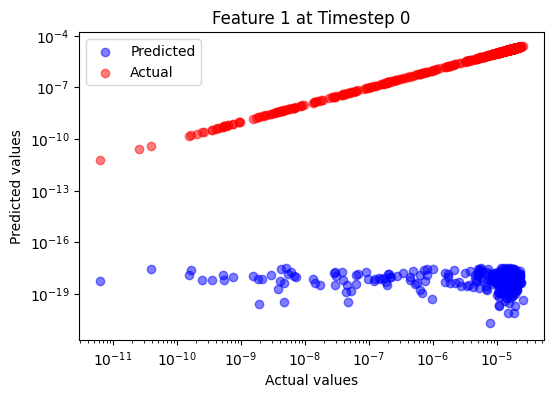

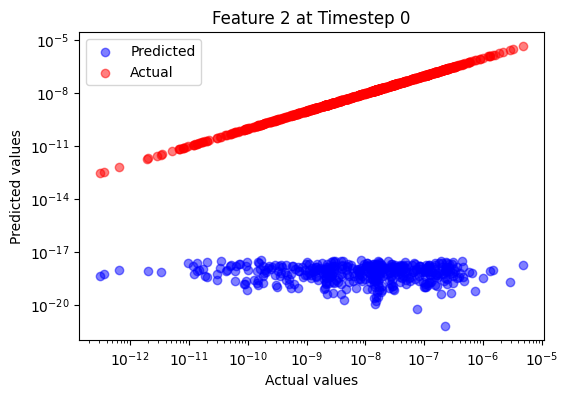

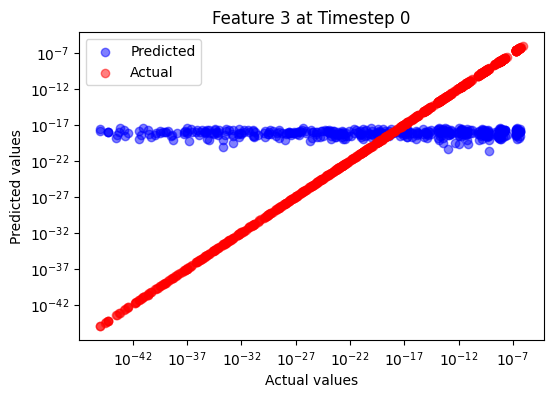

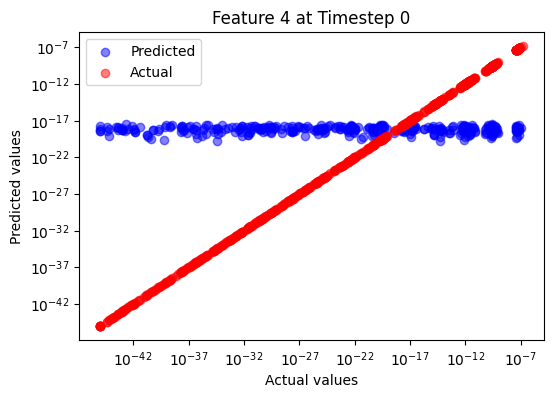

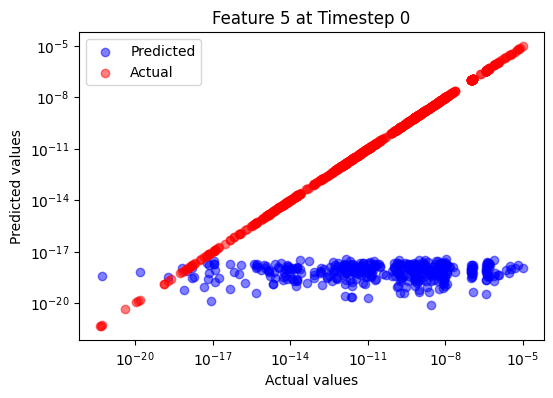

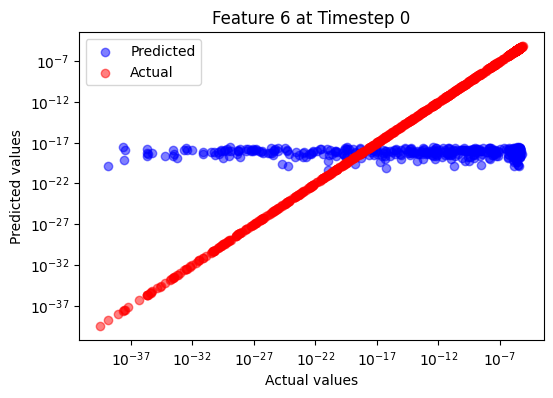

In [38]:
y_pred=model.predict(X_test)
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Create arrays for x and y coordinates for the best timestep
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Create the DataFrame for the best timestep
df_best_timestep = pd.DataFrame({
    'X': X,
    'Y': Y,
    **{f'feature_{i+1}': best_y_pred_flattened[:, i] for i in range(y_pred_shape[-1])}
})

# Save the DataFrame to a CSV file
df_best_timestep.to_csv('data/PINN.csv', index=False)

# Verify shapes
print(best_y_test_flattened.shape)
print(best_y_pred_flattened.shape)

# Create plots for the best timestep
output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

num_features = best_y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(best_y_test_flattened[:, i], best_y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(best_y_test_flattened[:, i], best_y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'Feature {i+1} at Timestep {best_timestep}')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # Save the plot to the specified folder
    plot_filename = f'feature_{i+1}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()